<a href="https://colab.research.google.com/github/AndreMarcato/Planerg_2023/blob/main/Series_Sinteticas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install PySDDP
!pip install tabulate

In [26]:
from PySDDP.Pen import Newave
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from random import randint
import os

In [27]:
# Caminho do Newave com os dados publicados em agosto

Caminho = './NW202308_UNSI_ACL'

PMOSET2023 = Newave(Caminho)
print(os.listdir(Caminho))

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 99 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 2 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.
['ADTERM.DAT', 'AGRINT.DAT', 'ARQUIVOS.DAT', 'BID.DAT', 'CASO.DAT', 'CDEFVAR.DAT', 'CLAST.DAT', 'CONFHD.DAT', 'CONFT.DAT', 'CURVA.DAT', 'CVAR.DAT', 'C_ADIC.DAT', 'DGER.DAT', 'DSVAGUA.DAT', 'ELNINO.DAT', 'ENSOAUX.DAT', 'EXPH.DAT', 'EXPT.DAT', 'FORMAT.TMP', 'GHMIN.DAT', 'GTMINPAT.DAT', 'GTMIN_CCEE_082023.xlsx', 'HIDR.DAT', 'ITAIPU.DAT', 'LOSS.DAT', 'MANUTT.DAT', 'MENSAG.TMP', 'MODIF.DAT'

dict_keys(['codigo', 'nome', 'posto', 'ree', 'vol_ini', 'status', 'modif', 'ano_i', 'ano_f', 'bdh', 'sist', 'empr', 'jusante', 'desvio', 'vol_min', 'vol_max', 'vol_vert', 'vol_min_desv', 'cota_min', 'cota_max', 'pol_cota_vol', 'pol_cota_area', 'coef_evap', 'num_conj_maq', 'maq_por_conj', 'pef_por_conj', 'cf_hbqt', 'cf_hbqt_2', 'cf_hbqt_3', 'cf_hbqt_4', 'cf_hbqt_5', 'cf_hbqg', 'cf_hbqg_2', 'cf_hbqg_3', 'cf_hbqg_4', 'cf_hbqg_5', 'cf_hbpt', 'cf_hbpt_2', 'cf_hbpt_3', 'cf_hbpt_4', 'cf_hbpt_5', 'alt_efet_conj', 'vaz_efet_conj', 'prod_esp', 'perda_hid', 'num_pol_vnj', 'pol_vaz_niv_jus', 'pol_vaz_niv_jus_2', 'pol_vaz_niv_jus_3', 'pol_vaz_niv_jus_4', 'pol_vaz_niv_jus_5', 'cota_ref_nivel_jus', 'cfmed', 'inf_canal_fuga', 'fator_carga_max', 'fator_carga_min', 'vaz_min', 'unid_base', 'tipo_turb', 'repres_conj', 'teifh', 'ip', 'tipo_perda', 'data', 'observ', 'vol_ref', 'tipo_reg', 'vazoes', 'vol_mint', 'vol_maxt', 'vol_minp', 'vaz_mint', 'cmont', 'cfugat', 'vol_util', 'pot_efet', 'vaz_efet', 'status

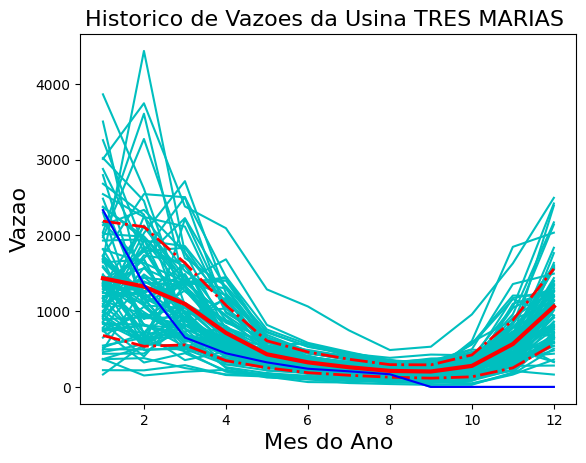

In [28]:
# Solicita ao usuário que insira a usina
usina = input("Digite o nome da Usina: ")
x = np.arange(0,12,1)
Usina = PMOSET2023.confhd.get(usina)

print(Usina.keys())
print(Usina['vazoes'])
print(np.shape(Usina['vazoes']))
PMOSET2023.confhd.plot_vaz(Usina)


In [29]:
from cvxopt import matrix, solvers

mes = int(input('Mês para estipulação: '))
years = np.shape(Usina['vazoes'])[0]-2
vaz_atual = np.array(Usina['vazoes'][years+1]) # Afluencias históricas do ano atual
mes=mes-1
mes_saida =2
mes_desejado = mes
coefs=[]
matriz_residuos=[]
mes=mes_saida
dados=[]

while (mes_desejado>=mes):
    erro=np.inf
    for meses in range(1,12):
        mes_inicial = mes - meses
        mi=mes_inicial
        years = np.shape(Usina['vazoes'])[0]-2
        identidade = np.eye(years)


        if (mes_inicial<0):
            mes_inicial += 12
            identidade = np.eye(years-1)

        if (mes==0):
            recorte = Usina['vazoes'][0:years-1,mes_inicial:12]
            Aeq = np.concatenate((recorte, identidade), axis = 1)
            Beq = Usina['vazoes'][0:years-1,mes:mes+1]


        elif (mes < meses):
            recorte = Usina['vazoes'][0:years-1,mes_inicial:12]
            recorte2 = Usina['vazoes'][1:years,0:mes]
            Aeq = np.concatenate((recorte, recorte2, identidade), axis = 1)
            Beq = Usina['vazoes'][0:years-1,mes:mes+1]


        else:
            recorte = Usina['vazoes'][0:years,mes_inicial:mes]
            Aeq = np.concatenate((recorte, identidade), axis = 1)
            Aeq = matrix(Aeq)
            Beq = Usina['vazoes'][0:years,mes:mes+1]
            

        Aeq = matrix(Aeq)
        Beq = matrix(Beq)*1.0

        if mi<0:
            q = matrix(np.zeros(years+meses-1))
            P = 2*np.eye(years+meses-1)
            A = matrix(0.0, (0,years+meses-1))
        else:
            q = matrix(np.zeros(years+meses))
            P = 2*np.eye(years+meses)
            A = matrix(0.0, (0,years+meses))

        #for i in range(0,meses):
        #    P[i][i] = 0

        for i in range(meses,years+1):
           P[i][i] *= ((i+meses)/meses)

        P = matrix(P)
        B = matrix(0.0, (0,1))

        solvers.options['show_progress'] = False
        abstol = 1e-9
        reltol = 1e-9
        # sol = solvers.qp(P, q, A.T, B, Aeq.T, Beq, abstol=abstol, reltol=reltol)
        # sol = solvers.qp(P, q, G=-A.T, h=-B, A=Aeq.T, b=Beq, kktsolver='ldl', abstol=abstol, reltol=reltol)
        # sol = solvers.qp(P, q, G=-A.T, h=B, A=Aeq.T, b=Beq, kktsolver='ldl', abstol=abstol, reltol=reltol)
        sol = solvers.qp(P, q, A, B, A=Aeq, b=Beq, abstol=abstol, reltol=reltol)
        erros = sol['x'][meses:]
        if(np.abs(erro) > np.sum(np.abs(erros))): 
            residuos=sol['x'][meses:]
            erro = np.sum(np.abs(erros))
            phi = []
            num_coef = meses
            coeficientes = sol['x'][:meses]
            # Os dados abaixo são importantes pois permitem o a estimação das afluências desejadas através de afluências históricas e coeficientes calculados
            vaz_anterior = np.array(Usina['vazoes'][years]) + vaz_atual # Afluencias históricas do ano anterior

            vaz=0
            # Esse loop é responsável por cálcular as vazões do mês atual que se deseja, com os coeficientes obtidos através do solver
            for i in range(meses):  
                if (mes==0): #se o mês de análise for janeiro
                    vaz += coeficientes[i]*vaz_anterior[mes_inicial:12][i]
                elif (mes < meses): # se o número de meses de base for maior que o mês de análise (precisa de vazões de anos anteriores)
                    if i < (meses - mes):
                        vaz += coeficientes[i]*vaz_anterior[mes_inicial:12][i]
                    else:
                        vaz += coeficientes[i]*vaz_atual[0:mes][i-meses+mes]
                else:   # se o número de meses base for menor que o mês de análise (precisou-se de vazoes apenas do ano em questão)
                    vaz += coeficientes[i]*vaz_atual[mes_inicial:mes][i]
    vaz_atual[mes] = vaz
    mes += 1
    dados_mes = {
        "Mes": mes,
        "Erros": residuos,
        "Ordem": num_coef,
        "SomaErros": erro,
        "Coefs": coeficientes
    }
    dados.append(dados_mes)
    coefs.append(phi)
    matriz_residuos.append(residuos)
resultado = {
    "Vazoes": vaz_atual,
    "Dados": dados,
  }
for i in range(0,mes-mes_saida):
    print(np.shape(resultado['Dados'][i]['Coefs']))
    # print(resultado['Dados'][i]['Coefs'])
print(vaz_atual)

(11, 1)
(11, 1)
(11, 1)
(11, 1)
(6, 1)
(1, 1)
(8, 1)
(11, 1)
(10, 1)
(11, 1)
[2333 1351 2176 1281  682  556  429  342  303  191  312 1436]


In [30]:
""" from scipy.optimize import minimize

recorte = Usina['vazoes'][0:91, 4:7]
identidade = np.eye(91)

Aeq = np.concatenate((recorte, identidade), axis=1)
Beq = Usina['vazoes'][0:91, 7:8]


# Função objetivo
def objective(x):
    y=x
    y[0]=x[0]
    y[1]=x[1]
    y[2]=x[2]
    for i in range(3, 94):
        y[i] = abs(x[i])
    return 0.5 * np.dot(y, np.dot(P, y))

# Restrições de igualdade
def constraint_eq(x):
    return np.dot(Aeq, x) - Beq.flatten()  # Flattening Beq to match dimensions

x0 = np.zeros(94)  # Chute inicial

# Resolvendo o problema de otimização
result = minimize(objective, x0, constraints={'type': 'eq', 'fun': constraint_eq})
coeficientes = result.x[:3]

erros = result.x[3:]
print(erros)
erros = erros.reshape((91, 1))
print("Coeficientes:", coeficientes)
print("Erros:", erros) """


' from scipy.optimize import minimize\n\nrecorte = Usina[\'vazoes\'][0:91, 4:7]\nidentidade = np.eye(91)\n\nAeq = np.concatenate((recorte, identidade), axis=1)\nBeq = Usina[\'vazoes\'][0:91, 7:8]\n\n\n# Função objetivo\ndef objective(x):\n    y=x\n    y[0]=x[0]\n    y[1]=x[1]\n    y[2]=x[2]\n    for i in range(3, 94):\n        y[i] = abs(x[i])\n    return 0.5 * np.dot(y, np.dot(P, y))\n\n# Restrições de igualdade\ndef constraint_eq(x):\n    return np.dot(Aeq, x) - Beq.flatten()  # Flattening Beq to match dimensions\n\nx0 = np.zeros(94)  # Chute inicial\n\n# Resolvendo o problema de otimização\nresult = minimize(objective, x0, constraints={\'type\': \'eq\', \'fun\': constraint_eq})\ncoeficientes = result.x[:3]\n\nerros = result.x[3:]\nprint(erros)\nerros = erros.reshape((91, 1))\nprint("Coeficientes:", coeficientes)\nprint("Erros:", erros) '

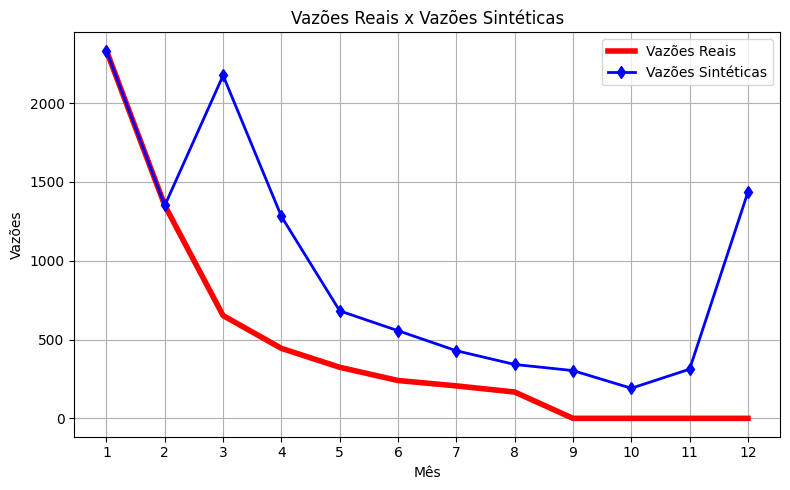

In [31]:
x = np.arange(0,12,1)


plt.figure(figsize=(8,5))


plt.plot(x+1, Usina['vazoes'][92,:],color='r',linewidth=4.0,label='Vazões Reais')
plt.plot(x+1, vaz_atual, marker='d',color='b',linewidth=2.0,label='Vazões Sintéticas')
plt.title("Vazões Reais x Vazões Sintéticas")
plt.xlabel("Mês")
plt.ylabel("Vazões")
plt.xticks(x+1)
plt.grid()
plt.legend()
plt.tight_layout()

[2333 1351 2176 1281  682  556  429  342  303  191  312 1436]


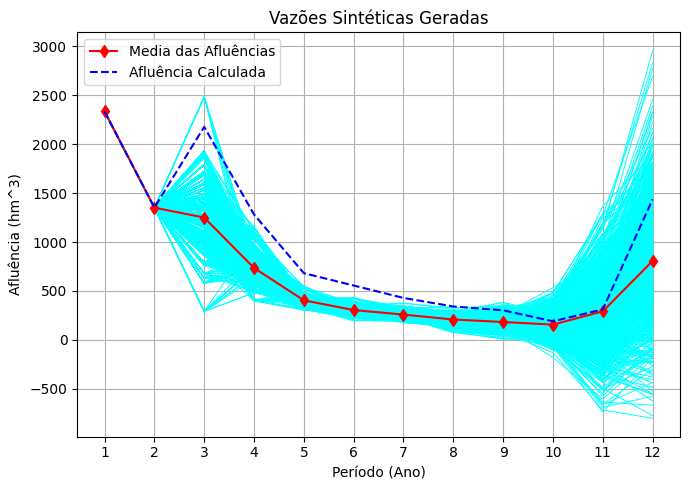

In [32]:
import random
import numpy as np
import matplotlib.pyplot as plt

afl_us = vaz_atual
print(afl_us)
vaz_anteriores = np.array(Usina['vazoes'][years]) # Vazoes do ano anterior
sintetica = []
NS = 1000
for k in range(NS):  
  vaz_atual = np.array(Usina['vazoes'][years+1]) # Vazoes do ano atual
  for j, imes in enumerate(resultado["Dados"]):
    vazao = 0
    for i in range(imes["Ordem"]):
      if (imes["Mes"]-1==0):
        mes_inicial = 12 + (imes["Mes"]-1) - imes["Ordem"]
        mes_final = 12
        vazao += imes["Coefs"][i]*vaz_anteriores[mes_inicial:mes_final][i]
      elif (imes["Mes"]-1 < imes["Ordem"]):
        mes_inicial = 12 + (imes["Mes"]-1) - imes["Ordem"]
        mes_final = 12
        if i < (imes["Ordem"] - (imes["Mes"]-1)):
          vazao += imes["Coefs"][i]*vaz_anteriores[mes_inicial:mes_final][i]
        else:
          vazao += imes["Coefs"][i]*vaz_atual[0:(imes["Mes"]-1)][i-imes["Ordem"]+(imes["Mes"]-1)]
      else:
        mes_inicial = (imes["Mes"]-1) - imes["Ordem"]
        mes_final = (imes["Mes"]-1)
        vazao += imes["Coefs"][i]*vaz_atual[mes_inicial:mes_final][i]
    vaz_atual[(imes["Mes"]-1)] = vazao + imes["Erros"][random.randint(0, np.shape(imes["Erros"])[0])-1]  # Acréscimo da aleatóriedade
  aux = {
      "Vazoes": vaz_atual
  }
  sintetica.append(aux)

x = np.arange(1,13)
# Converter "Vazoes" para uma única matriz numpy
vazoes_arrays = np.array([d['Vazoes'] for d in sintetica])

# Calcular a média das vazões
media_vazoes = np.mean(vazoes_arrays, axis=0)

plt.figure(figsize=(7,5))
for i, isin in enumerate(sintetica):
  plt.plot(x, isin["Vazoes"], linewidth = 0.7, color = 'cyan')
plt.plot(x, media_vazoes, label = "Media das Afluências", marker = "d", color = 'r')
plt.plot(x, afl_us, "--", label = "Afluência Calculada", color = 'b')
plt.title("Vazões Sintéticas Geradas")
plt.xlabel("Período (Ano)")
plt.ylabel("Afluência (hm^3)")
plt.legend()
plt.xticks(x)
plt.grid()
plt.tight_layout()

In [33]:
from tabulate import tabulate

dados = np.array(resultado['Dados'])

for d in dados:
    del d["Erros"]
    del d["Coefs"]

colunas = dados[0].keys()


tabela = tabulate([list(d.values()) for d in dados], headers=colunas, tablefmt="grid")

print(tabela)

+-------+---------+-------------+
|   Mes |   Ordem |   SomaErros |
+=======+=========+=============+
|     3 |      11 |    23527.7  |
+-------+---------+-------------+
|     4 |      11 |    10890.9  |
+-------+---------+-------------+
|     5 |      11 |     3300.58 |
+-------+---------+-------------+
|     6 |      11 |     2255.97 |
+-------+---------+-------------+
|     7 |       6 |     1619.24 |
+-------+---------+-------------+
|     8 |       1 |     1688.48 |
+-------+---------+-------------+
|     9 |       8 |     3135.45 |
+-------+---------+-------------+
|    10 |      11 |     7108.3  |
+-------+---------+-------------+
|    11 |      10 |    15769    |
+-------+---------+-------------+
|    12 |      11 |    28073.1  |
+-------+---------+-------------+


In [34]:

erro_tot =  Beq + erros
erro_total=0
for i in range(0, 91):
        erro_total = np.sqrt((erro_total**2) + (erros[i]**2))
print(erro_total)

3816.9639872191246
